In [15]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
## get mappings of sid (a random number) to systems (adslabs) that are in the OC20 dataset 
with open("oc20_data_mapping.pkl", "rb") as input_file:
    mappings = pickle.load(input_file)

In [18]:
# load the surface sid: surface anomalies binary vector for each val set
df_val_id_anom = pd.read_csv("is2re_val_sets_anom/is2re_val_id_surf_anom.csv", index_col=0)
df_ood_ads_anom = pd.read_csv("is2re_val_sets_anom/is2re_val_ood_ads_surf_anom.csv", index_col=0)
df_ood_cat_anom = pd.read_csv("is2re_val_sets_anom/is2re_val_ood_cat_surf_anom.csv", index_col=0)
df_ood_both_anom = pd.read_csv("is2re_val_sets_anom/is2re_val_ood_both_surf_anom.csv", index_col=0)

In [3]:
# load the is2re val sets with the DFT energies
df_val_id = pd.read_csv("is2re_val_sets/is2re_val_id.csv", index_col=0)
df_ood_ads = pd.read_csv("is2re_val_sets/is2re_val_ood_ads.csv", index_col=0)
df_ood_cat = pd.read_csv("is2re_val_sets/is2re_val_ood_cat.csv", index_col=0)
df_ood_both = pd.read_csv("is2re_val_sets/is2re_val_ood_both.csv", index_col=0)

In [19]:
for df, df_anom in [(df_val_id,df_val_id_anom),(df_ood_ads,df_ood_ads_anom),
                    (df_ood_cat,df_ood_cat_anom),(df_ood_both,df_ood_both_anom)]:
    sorted_surf_anom = []
    for sid in tqdm(df["sid"].values):
        sid = "random" + str(sid)
        surf_anomalies = df_anom["surface_anomalies"].values
        sorted_surf_anom.append(surf_anomalies[np.where(df_anom["sid"].values==sid)[0][0]])
    df["surface_anomalies"] = sorted_surf_anom

100%|██████████| 24987/24987 [00:12<00:00, 2013.34it/s]


In [20]:
# pick only systems without recontructions
df_val_id = df_val_id.query("surface_anomalies==0")
df_ood_ads = df_ood_ads.query("surface_anomalies==0")
df_ood_cat = df_ood_cat.query("surface_anomalies==0")
df_ood_both = df_ood_both.query("surface_anomalies==0")

In [5]:
## MAE distribution of the MAEs
for df in [df_val_id,df_ood_cat,df_ood_ads,df_ood_both]:
    material_classes = []
    for i in tqdm(df["sid"].values):
        sid = "random"+str(i)
        material_classes.append(mappings[sid]["class"])
    material_classes = np.array(material_classes)
    # add system information to the dataframe
    df["cat_class"] = material_classes

100%|██████████| 24987/24987 [00:00<00:00, 495632.95it/s]


In [12]:
df_val_id["ml_relax_ads_energy"] = df_val_id["ml_relax_total_energy"] \
                                    - df_val_id["ml_relax_slab_energy"] \
                                    - df_val_id["dft_adsorbate_energy"]
df_ood_ads["ml_relax_ads_energy"] = df_ood_ads["ml_relax_total_energy"] \
                                    - df_ood_ads["ml_relax_slab_energy"] \
                                    - df_ood_ads["dft_adsorbate_energy"]
df_ood_cat["ml_relax_ads_energy"] = df_ood_cat["ml_relax_total_energy"] \
                                    - df_ood_cat["ml_relax_slab_energy"] \
                                    - df_ood_cat["dft_adsorbate_energy"]
df_ood_both["ml_relax_ads_energy"] = df_ood_both["ml_relax_total_energy"]\
                                    - df_ood_both["ml_relax_slab_energy"]\
                                    - df_ood_both["dft_adsorbate_energy"]

In [21]:
# regenrate the figure in Adeesh's paper on about the ML errors across the material classes
val_id_dict = {}
for material in [0,1,2,3]:
    val_id_dict[material] = np.mean(np.abs(df_val_id.query(f"cat_class=={material}")["ml_relax_ads_energy"] \
                                             - df_val_id.query(f"cat_class=={material}")["dft_adsorption_energy"]))
val_ood_ads_dict = {}
for material in [0,1,2,3]:
    val_ood_ads_dict[material] = np.mean(np.abs(df_ood_ads.query(f"cat_class=={material}")["ml_relax_ads_energy"] \
                                             - df_ood_ads.query(f"cat_class=={material}")["dft_adsorption_energy"]))
val_ood_cat_dict = {}
for material in [0,1,2,3]:
    val_ood_cat_dict[material] = np.mean(np.abs(df_ood_cat.query(f"cat_class=={material}")["ml_relax_ads_energy"] \
                                             - df_ood_cat.query(f"cat_class=={material}")["dft_adsorption_energy"]))
val_ood_both_dict = {}
for material in [0,1,2,3]:
    val_ood_both_dict[material] = np.mean(np.abs(df_ood_both.query(f"cat_class=={material}")["ml_relax_ads_energy"] \
                                             - df_ood_both.query(f"cat_class=={material}")["dft_adsorption_energy"]))

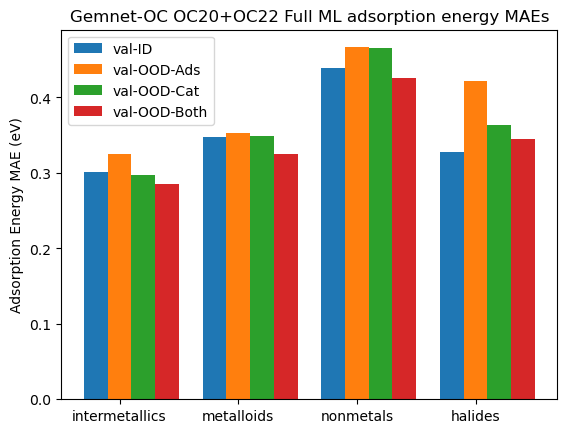

In [22]:
# Extract labels and mean values
materials = ["intermetallics", "metalloids", "nonmetals", "halides"]
labels = list(val_id_dict.keys())
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, list(val_id_dict.values()), width, label='val-ID')
rects2 = ax.bar(x, list(val_ood_ads_dict.values()), width, label='val-OOD-Ads')
rects3 = ax.bar(x + width, list(val_ood_cat_dict.values()), width, label='val-OOD-Cat')
rects4 = ax.bar(x + 2*width, list(val_ood_both_dict.values()), width, label='val-OOD-Both')

# Add legend
ax.legend()

# Add labels and title
ax.set_ylabel('Adsorption Energy MAE (eV)')
ax.set_title('Gemnet-OC OC20+OC22 Full ML adsorption energy MAEs')
ax.set_xticks(x)
ax.set_xticklabels(materials)

plt.show()